0. preprocessing
1. PCA
2. KMC
- <- tried exploring up to this point
3. Improving KMC Performance: cross validation, elbow
4. apply preprocessing before KMC <- this also done but just in a type-changing and default-normalizing way 
5. comparison with DBSCAN, SOM, RNN

In [36]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

# exploratory analysis 
import ydata_profiling as yp

# sklearn for clustering algorithms
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

pd.options.display.max_columns = None
sns.set_context("talk")
sns.set_style("whitegrid")

In [119]:
df_sku = pd.read_csv('./data/sku_noid.csv',
                 names=[
                    "unit_price", "outbound_number",
                    "total_outbound", "pal_gw", "pal_height", "units_pp"
                 ], skiprows=1, index_col=False)

df_super = pd.read_csv("./data/superstore_sample.csv")


/var/folders/cq/4vwhjr3125jb36fr9d1d8pdr0000gn/T/ipykernel_70417/2246527495.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df_sku = pd.read_csv('./data/sku_noid.csv',


In [52]:
# print(df_sku.shape)
# print(df_super.shape)

(2279, 6)
(9994, 21)


In [51]:
df_sku.head()

,unit_price,outbound_number,total_outbound,pal_gw,pal_height,units_pp
0,0.058,547,9,2441.0,105.60,1.56
1,0.954,547,0,0.0,207.68,1.00
2,2.385,547,12,23.0,165.78,1.02
3,5.100,547,0,0.0,221.04,1.05
4,0.000,547,0,0.0,0.00,0.00


In [55]:
df_super.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [58]:
df_super.dtypes

Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object

In [120]:
# Superstore dataset

# type change: obj -> str
df_super['Customer ID'] = df_super['Customer ID'].astype("string")
df_super['City'] = df_super['City'].astype("string")
df_super['State'] = df_super['State'].astype("string")
df_super['Postal Code'] = df_super['Postal Code'].astype("string")
df_super['Product ID'] = df_super['Product ID'].astype("string")
df_super['Product Name'] = df_super['Product Name'].astype("string")
df_super['Sub-Category'] = df_super['Sub-Category'].astype("string")

# type change: obj -> category 
df_super['Ship Mode'] = df_super['Ship Mode'].astype("category")
df_super['Segment'] = df_super['Segment'].astype("category")
df_super['Region'] = df_super['Region'].astype("category")
df_super['Category'] = df_super['Category'].astype("category")
# df_super['Sub-Category'] = df_super['Sub-Category'].astype("category")

# type change: obj -> datetime
df_super['Order Date'] = pd.to_datetime(df_super['Order Date'])
df_super['Ship Date'] = pd.to_datetime(df_super['Ship Date'])

In [121]:
# columns with no value: Order ID, Customer Name, Country
df_super_f = df_super.loc[:, ~df_super.columns.isin(['Order ID', 'Customer Name', 'Country'])]

In [82]:
df_super_f.dtypes

Row ID                   int64
Order Date      datetime64[ns]
Ship Date       datetime64[ns]
Ship Mode             category
Customer ID             string
Segment               category
City                    string
State                   string
Postal Code             string
Region                category
Product ID              string
Category              category
Sub-Category          category
Product Name            string
Sales                  float64
Quantity                 int64
Discount               float64
Profit                 float64
dtype: object

In [74]:
# df_super_f.iloc[:,1:].describe(include="all")

/var/folders/cq/4vwhjr3125jb36fr9d1d8pdr0000gn/T/ipykernel_70417/98600501.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_super_f.iloc[:,1:].describe(include="all")
/var/folders/cq/4vwhjr3125jb36fr9d1d8pdr0000gn/T/ipykernel_70417/98600501.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_super_f.iloc[:,1:].describe(include="all")


,Order Date,Ship Date,Ship Mode,Customer ID,Segment,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
count,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994.000000,9994.000000,9994.000000,9994.000000
unique,1237,1334,4,793,3,531,49,631,4,1862,3,17,1850,NaN,NaN,NaN,NaN
top,2016-09-05 00:00:00,2015-12-16 00:00:00,Standard Class,WB-21850,Consumer,New York City,California,10035,West,OFF-PA-10001970,Office Supplies,Binders,Staple envelope,NaN,NaN,NaN,NaN
freq,38,35,5968,37,5191,915,2001,263,3203,19,6026,1523,48,NaN,NaN,NaN,NaN
first,2014-01-03 00:00:00,2014-01-07 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2017-12-30 00:00:00,2018-01-05 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,229.858001,3.789574,0.156203,28.656896
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,623.245101,2.225110,0.206452,234.260108
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.444000,1.000000,0.000000,-6599.978000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.280000,2.000000,0.000000,1.728750


In [108]:
# report_sku = df_sku.profile_report()
# report_sku.to_file(output_file="0403_sku_report.html")
# exclude columns of no value
# report_super_f = df_super_f.iloc[:,1:].profile_report()
# report_super_f.to_file(output_file="0403_super_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/silmari/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
# df_sku.describe(include="all")

,unit_price,outbound_number,total_outbound,pal_gw,pal_height,units_pp
count,2280,2280,2280,2280,2280,2280
unique,7,502,724,287,57,104
top,547,0,0,0,0,108
freq,1250,979,979,371,787,303


In [17]:
# df_super.describe(include="all")

/var/folders/cq/4vwhjr3125jb36fr9d1d8pdr0000gn/T/ipykernel_70417/3187602383.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_super.describe(include="all")
/var/folders/cq/4vwhjr3125jb36fr9d1d8pdr0000gn/T/ipykernel_70417/3187602383.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_super.describe(include="all")


,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
count,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994.000000,9994,9994,9994,9994,9994,9994.000000,9994.000000,9994.000000,9994.000000
unique,5009,1237,1334,4,793,793,3,1,531,49,NaN,4,1862,3,17,1850,NaN,NaN,NaN,NaN
top,CA-2017-100111,2016-09-05 00:00:00,2015-12-16 00:00:00,Standard Class,WB-21850,William Brown,Consumer,United States,New York City,California,NaN,West,OFF-PA-10001970,Office Supplies,Binders,Staple envelope,NaN,NaN,NaN,NaN
freq,14,38,35,5968,37,37,5191,9994,915,2001,NaN,3203,19,6026,1523,48,NaN,NaN,NaN,NaN
first,NaN,2014-01-03 00:00:00,2014-01-07 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2017-12-30 00:00:00,2018-01-05 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55190.379428,NaN,NaN,NaN,NaN,NaN,229.858001,3.789574,0.156203,28.656896
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32063.693350,NaN,NaN,NaN,NaN,NaN,623.245101,2.225110,0.206452,234.260108
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1040.000000,NaN,NaN,NaN,NaN,NaN,0.444000,1.000000,0.000000,-6599.978000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23223.000000,NaN,NaN,NaN,NaN,NaN,17.280000,2.000000,0.000000,1.728750


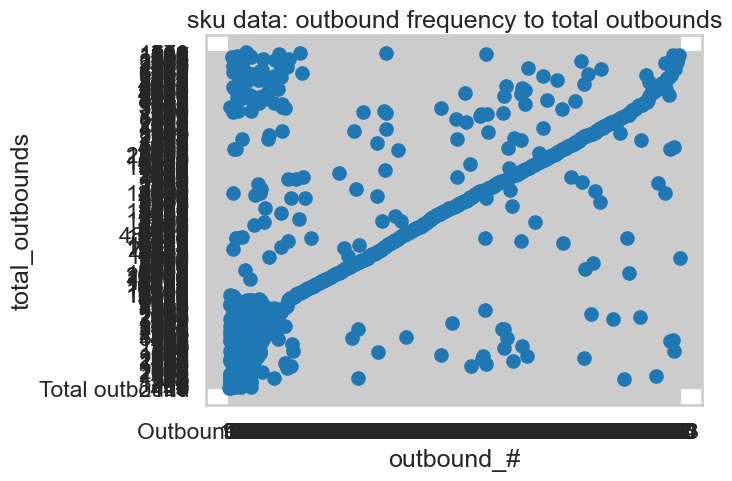

In [31]:
# plt.scatter(df_sku.iloc[:, 1], df_sku.iloc[:, 2])
# plt.xlabel("outbound_#")
# plt.ylabel("total_outbounds")
# plt.title("sku data: outbound frequency to total outbounds")
# plt.show()

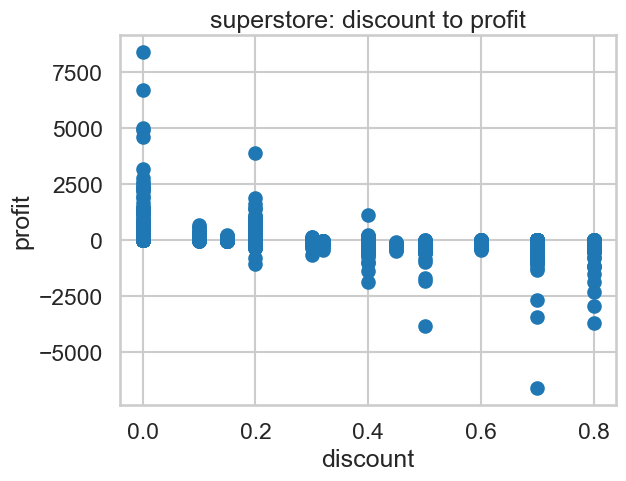

In [83]:
# plt.scatter(df_super_f.iloc[:, 16], df_super_f.iloc[:, 17])
# plt.xlabel("discount")
# plt.ylabel("profit")
# plt.title("superstore: discount to profit")
# plt.show()

In [123]:
le_super = LabelEncoder()
string_columns = [
    "Customer ID",
    "City", 
    "State",
    "Postal Code",
    "Product ID",
    "Product Name",
    "Sub-Category" #since it has 17 categorical values
]
for i in string_columns:
    df_super_f[i] = le_super.fit_transform(df_super_f[i])

/var/folders/cq/4vwhjr3125jb36fr9d1d8pdr0000gn/T/ipykernel_70417/4161937547.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_super_f[i] = le_super.fit_transform(df_super_f[i])
/var/folders/cq/4vwhjr3125jb36fr9d1d8pdr0000gn/T/ipykernel_70417/4161937547.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_super_f[i] = le_super.fit_transform(df_super_f[i])
/var/folders/cq/4vwhjr3125jb36fr9d1d8pdr0000gn/T/ipykernel_70417/4161937547.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [124]:
# encode category datatype
category_columns = [
    "Ship Mode", #4
    "Segment", #3
    "Region", #4
    "Category", #3
    # "Sub-Category" #17
]

for i in category_columns:
    ohe_super_f = OneHotEncoder()
    ohe_df_super_f = pd.DataFrame(
        ohe_super_f.fit_transform(
            df_super_f[[i]]
        ).toarray())
    # add suffix to column names in ohe_df
    ohe_df_super_f = ohe_df_super_f.add_suffix(i)  
    df_super_f = df_super_f.join(ohe_df_super_f)

In [125]:
# datetime to int
df_super_f['Order Date'] = df_super_f['Order Date'].astype(int) / 10**14
df_super_f['Ship Date'] = df_super_f['Ship Date'].astype(int) / 10**14

In [126]:
# dropping the category columns and scaling the data
scaler = StandardScaler()
scaled_df_super_f = scaler.fit_transform(
    df_super_f.drop(category_columns, axis=1))

In [127]:
df_super_f.dtypes

Row ID             int64
Order Date       float64
Ship Date        float64
Ship Mode       category
Customer ID        int64
Segment         category
City               int64
State              int64
Postal Code        int64
Region          category
Product ID         int64
Category        category
Sub-Category       int64
Product Name       int64
Sales            float64
Quantity           int64
Discount         float64
Profit           float64
0Ship Mode       float64
1Ship Mode       float64
2Ship Mode       float64
3Ship Mode       float64
0Segment         float64
1Segment         float64
2Segment         float64
0Region          float64
1Region          float64
2Region          float64
3Region          float64
0Category        float64
1Category        float64
2Category        float64
dtype: object

In [130]:
type(scaled_df_super_f)

numpy.ndarray

In [138]:
# perform PCA
pca4 = PCA(n_components=4)
pca_df_super4 = pca4.fit_transform(scaled_df_super_f)
pca2 = PCA(n_components=2)
pca_df_super2 = pca2.fit_transform(scaled_df_super_f)

In [86]:
# import pandas as pd
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# # create sample data with 4 features of different data types
# data = {'date': ['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04'],
#         'category': ['A', 'B', 'A', 'C'],
#         'string': ['foo', 'bar', 'baz', 'qux'],
#         'int': [1, 2, 3, 4]}
# df = pd.DataFrame(data)

# # convert datetime column to numerical values
# df['date'] = pd.to_datetime(df['date'])
# df['date'] = df['date'].astype(int) / 10**14

# # encode string column using label encoding
# le = LabelEncoder()
# df['string'] = le.fit_transform(df['string'])

# # encode category column using one-hot encoding
# ohe = OneHotEncoder()
# ohe_df = pd.DataFrame(ohe.fit_transform(df[['category']]).toarray())
# df = df.join(ohe_df)

# # convert all column names to strings
# df.columns = df.columns.astype(str)

# # scale the data
# scaler = StandardScaler()
# scaled_df = scaler.fit_transform(df.drop(['category'], axis=1))

# # perform PCA
# pca = PCA(n_components=2)
# pca_df = pca.fit_transform(scaled_df)

# # print the results
# print(pca_df)

[[-1.52876691 -1.57683948]
 [-1.42297291  2.11963447]
 [-0.13862401 -0.7070316 ]
 [ 3.09036384  0.1642366 ]]


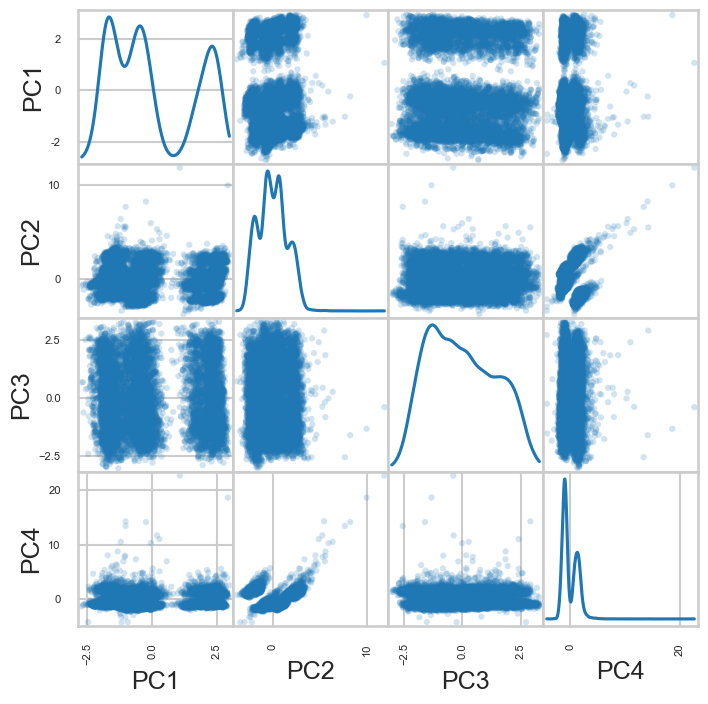

In [139]:
from pandas.plotting import scatter_matrix

pca_df_super_pd = pd.DataFrame(pca_df_super4, columns=['PC1', 'PC2', 'PC3', 'PC4'])
scatter_matrix(pca_df_super_pd, alpha=0.2, figsize=(8, 8), diagonal='kde')
plt.show()

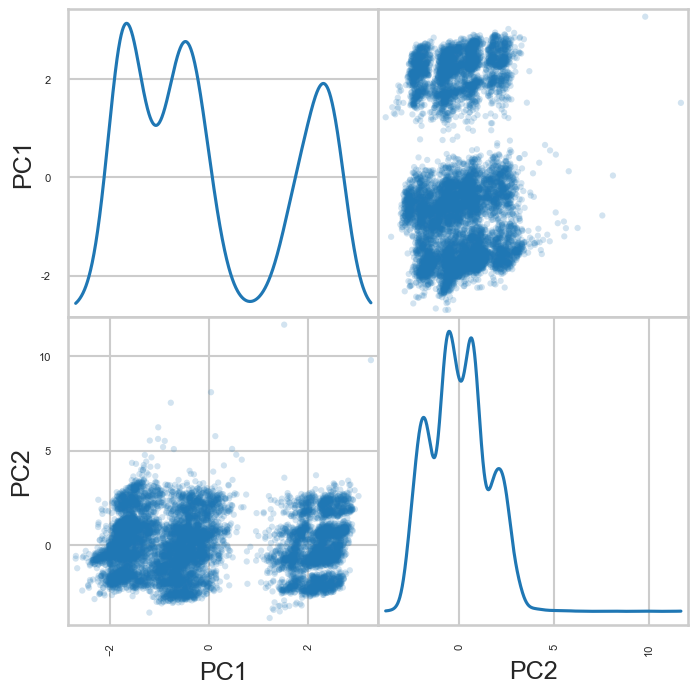

In [140]:
pca_df_super_pd2 = pd.DataFrame(pca_df_super2, columns=['PC1', 'PC2'])
scatter_matrix(pca_df_super_pd2, alpha=0.2, figsize=(8, 8), diagonal='kde')
plt.show()

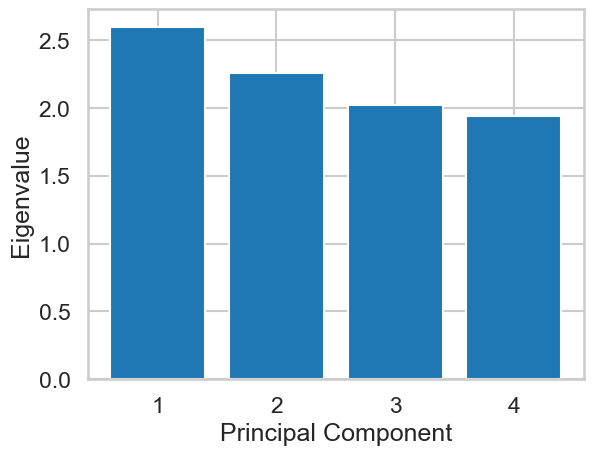

In [142]:
# Plot scree plot
plt.bar(np.arange(1, pca4.n_components_+1), pca4.explained_variance_)
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.show()

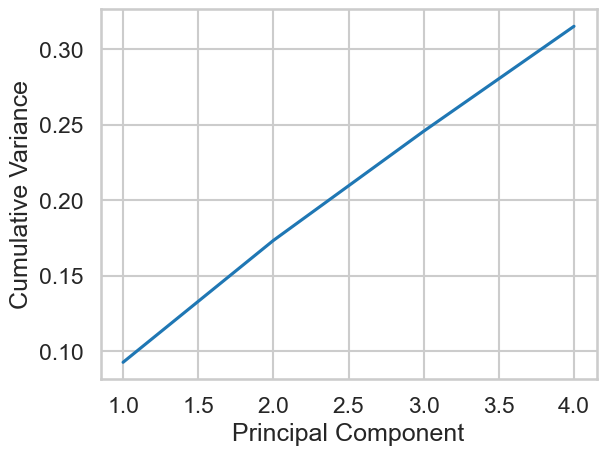

In [144]:
# Plot cumulative variance plot
plt.plot(np.arange(1, pca4.n_components_+1), np.cumsum(pca4.explained_variance_ratio_))
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Variance')
plt.show()

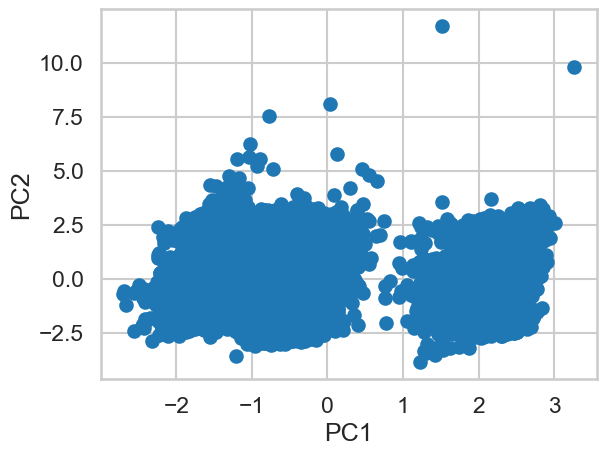

In [145]:
plt.scatter(pca_df_super2[:, 0], pca_df_super2[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

/Users/silmari/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


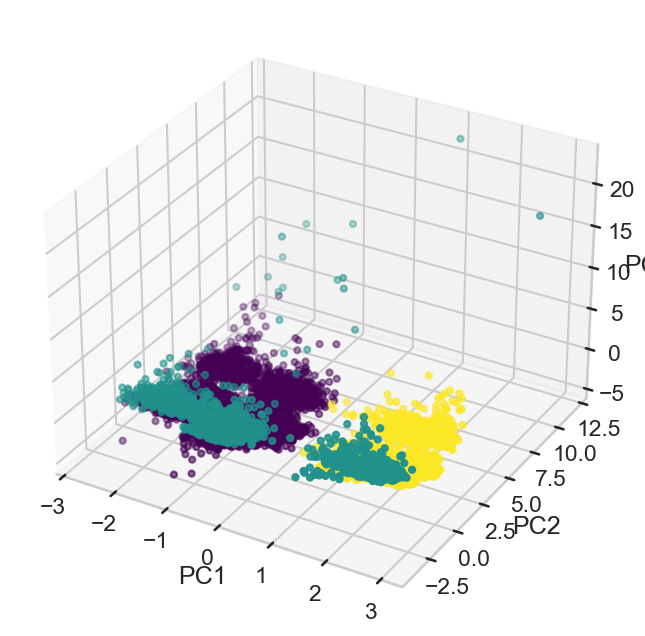

In [146]:
from sklearn.cluster import KMeans

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(pca_df_super4)

# Plot scatter plot with cluster labels
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df_super4[:, 0], pca_df_super4[:, 1], pca_df_super4[:, 3], c=kmeans.labels_, cmap='viridis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC4')
plt.show()

/Users/silmari/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


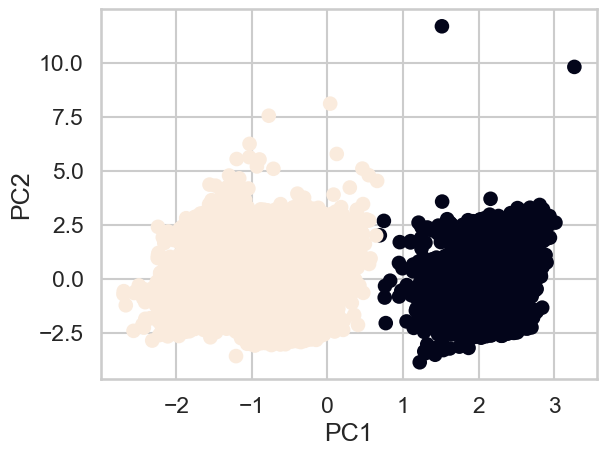

In [147]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(pca_df_super2[:, :2])

# Plot scatter plot with cluster labels
plt.scatter(pca_df_super2[:, 0], pca_df_super2[:, 1], c=kmeans.labels_)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [149]:
# checking for feature-wise contribution to each of the PCs
df_super_after_dropcol = df_super_f.drop(category_columns, axis=1)

# Get loadings for each feature in first two principal components
# access only PC1, PC2
loadings = pca4.components_[:2, :]

# Print loadings
for i, pc in enumerate(loadings):
    print(f"Principal Component {i+1}:")
    for j, feature in enumerate(df_super_after_dropcol.columns):
        print(f"{feature}: {pc[j]}")
    print()

Principal Component 1:
Row ID: 0.0038096951514606284
Order Date: 0.03153639383224873
Ship Date: 0.03146182541125151
Customer ID: 0.0003962830440504631
City: 0.15665962558203203
State: -0.35633088702710314
Postal Code: 0.5556505648792769
Product ID: 0.03937098960233671
Sub-Category: 0.02620484195108655
Product Name: 0.03201326382333375
Sales: 0.006859367923701422
Quantity: 0.010298697765713101
Discount: -0.12757882501432377
Profit: 0.030771104563155693
0Ship Mode: 0.013035334234328075
1Ship Mode: 0.017465067923468906
2Ship Mode: 0.00803779713270179
3Ship Mode: -0.024149935841439773
0Segment: 0.00040857057748238935
1Segment: -0.0075382894239884105
2Segment: 0.008508382183520334
0Region: -0.08132784297613899
1Region: -0.39137550043134023
2Region: -0.15492954328243677
3Region: 0.574536959336997
0Category: -0.006923908422036835
1Category: -0.023509825574872873
2Category: 0.036929751772833905

Principal Component 2:
Row ID: -0.012028747540026617
Order Date: 0.022732930660424467
Ship Date: 0.

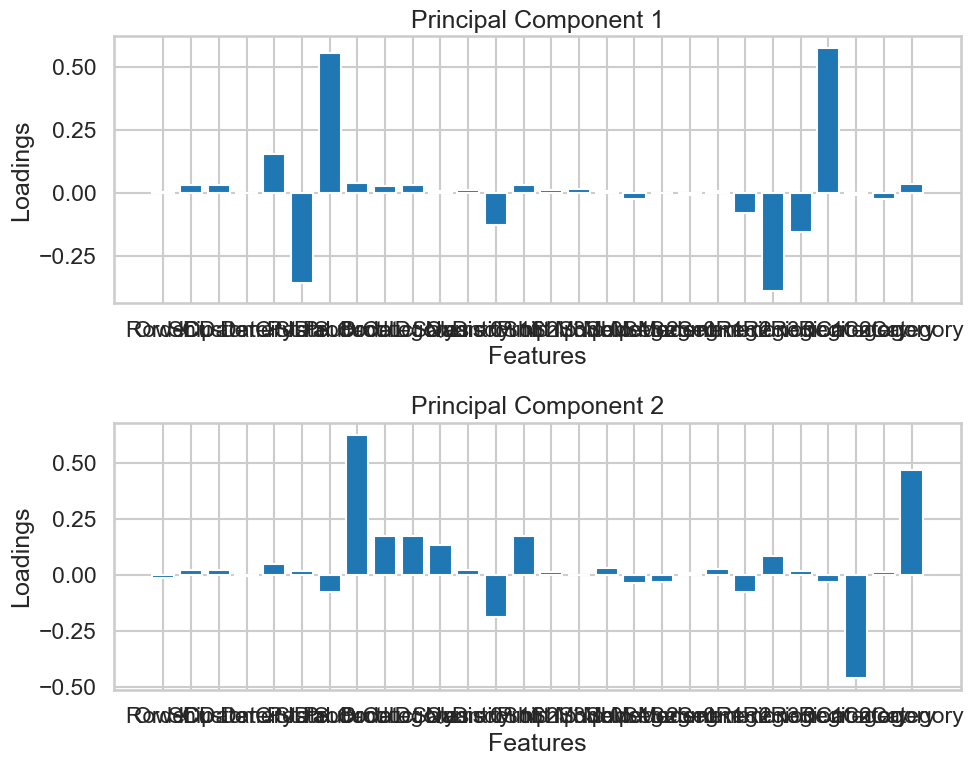

In [150]:
# Create bar plots of loadings for first two principal components
fig, ax = plt.subplots(nrows=2, figsize=(10, 8))

for i, pc in enumerate(loadings):
    ax[i].bar(df_super_after_dropcol.columns, pc)
    ax[i].set_title(f"Principal Component {i+1}")
    ax[i].set_xlabel("Features")
    ax[i].set_ylabel("Loadings")

plt.tight_layout()
plt.show()

In [151]:
pca_df = pca4.fit_transform(df_super_after_dropcol)

# Get loadings for each feature in principal components
loadings_df = pd.DataFrame(pca4.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4'], index=df_super_after_dropcol.columns)

# Print top 10 most contributing features for each principal component
for pc in range(1, 5):
    pc_col = f'PC{pc}'
    top10 = loadings_df[pc_col].abs().sort_values(ascending=False)[:10]
    print(f"Top 10 most contributing features for {pc_col}:")
    print(top10)
    print()

Top 10 most contributing features for PC1:
Row ID          0.999989
Product Name    0.003618
Product ID      0.001449
Order Date      0.001384
Ship Date       0.001384
Postal Code     0.001234
Profit          0.001017
City            0.000675
Sales           0.000309
State           0.000084
Name: PC1, dtype: float64

Top 10 most contributing features for PC2:
Sales           0.972334
Profit          0.196954
Product ID      0.106858
Product Name    0.061988
Ship Date       0.014050
Order Date      0.014034
Postal Code     0.007861
Customer ID     0.007300
City            0.001791
Quantity        0.000679
Name: PC2, dtype: float64

Top 10 most contributing features for PC3:
Product Name    0.727310
Product ID      0.685379
Sales           0.031715
Profit          0.014256
Postal Code     0.006128
Order Date      0.002783
Ship Date       0.002755
Sub-Category    0.002561
City            0.001827
Row ID          0.001677
Name: PC3, dtype: float64

Top 10 most contributing features for PC

In [ ]:
# .iloc[:,1:]